# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


. [Correlations](#correlations)


In [ ]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns



## Dataset Overview

This dataset comes from the **Sleep Apnea Detection Challenge** hosted by ENS (https://challengedata.ens.fr/participants/challenges/45/).

Each sample corresponds to a **90-second window** extracted from overnight polysomnography recordings.  
A total of **44 nights** were recorded, and from each night, **200 non-overlapping windows** were sampled.  

### Key characteristics:
- **Number of samples (windows):** 4400  
- **Number of raw features:** 72,000 (8 physiological signals × 9000 samples each)  
- **Signal sampling frequency:** 100 Hz  
- **Signal duration per window:** 90 seconds  
- **Number of channels (signals):** 8  
- **Labels:** 90 binary values (Y_0 … Y_89), one per second  

### Physiological signals:
1. Abdominal belt (AbdoBelt)  
2. Airflow  
3. Photoplethysmography (PPG)  
4. Thoracic belt  
5. Snoring indicator  
6. Peripheral oxygen saturation (SpO2)  
7. EEG derivation C4-A1  
8. EEG derivation O2-A1

Each row of the dataset follows this structure:

sample_id | subject_id | 72,000 flattened signal values



In [ ]:

# Load X
with h5py.File(r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\00_pre files\X_train.h5", "r") as f:
    key = list(f.keys())[0]
    X = f[key][:]
    
print("X shape:", X.shape)

# Load y
y_df = pd.read_csv(r"C:\Users\giuli\Documents\Open_Campus\Sleep_Apnea\00_pre files\y_train_tX9Br0C.csv")
print("y_train shape:", y_df.shape)

y_df.head()




X shape: (4400, 72002)
y_train shape: (4400, 91)


,ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,...,y_80,y_81,y_82,y_83,y_84,y_85,y_86,y_87,y_88,y_89
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Handling Missing Values

We inspect both the inputs (X) and the labels (y) to determine whether the dataset contains missing values.  
Since the signals come from medical devices and were pre-processed by the challenge creators, missing values are unlikely—but verification is still necessary.



In [6]:
# Check missing values in y_train
missing_y = y_df.isnull().sum()

print("Missing values in y_train:")
missing_y



Missing values in y_train:


ID      0
y_0     0
y_1     0
y_2     0
y_3     0
       ..
y_85    0
y_86    0
y_87    0
y_88    0
y_89    0
Length: 91, dtype: int64

In [7]:
# Check missing values in X (flattened signal matrix)
print("Missing values in X:", np.isnan(X).sum())


Missing values in X: 0


## Feature Distributions

We explore the distribution of physiological signals.  
Since each window contains 9000 samples per channel, visualizing all values is impractical. Instead, we compute summary statistics.

Below we extract summary metrics (mean, std, min, max) for each of the 8 channels.



In [8]:
# Reshape X to (n_samples, n_channels, n_timesteps)
signals_flat = X[:, 2:]
signals = signals_flat.reshape(X.shape[0], 8, 9000)

channel_names = [
    "Abdominal belt", "Airflow", "PPG",
    "Thoracic belt", "Snoring", "SpO2",
    "EEG C4-A1", "EEG O2-A1"
]

stats = []

for i, name in enumerate(channel_names):
    ch = signals[:, i, :].ravel()
    stats.append([name, np.mean(ch), np.std(ch), np.min(ch), np.max(ch)])

stats_df = pd.DataFrame(stats, columns=["Channel", "Mean", "Std", "Min", "Max"])
stats_df



,Channel,Mean,Std,Min,Max
0,Abdominal belt,5.888035,480.813087,-1145.483551,1181.553592
1,Airflow,-28.403486,57.311850,-455.254483,351.567086
2,PPG,-857.776287,1513.287953,-4995.011702,4348.314102
3,Thoracic belt,-9.012861,432.779134,-1187.903087,1183.393149
4,Snoring,693.812603,463.935759,-1171.444646,1224.009839
5,SpO2,91942.331172,16592.621038,6.680096,105313.695534
6,EEG C4-A1,0.000448,21.452712,-2521.738076,2555.461083
7,EEG O2-A1,-0.000134,20.702043,-2667.758233,2660.121977


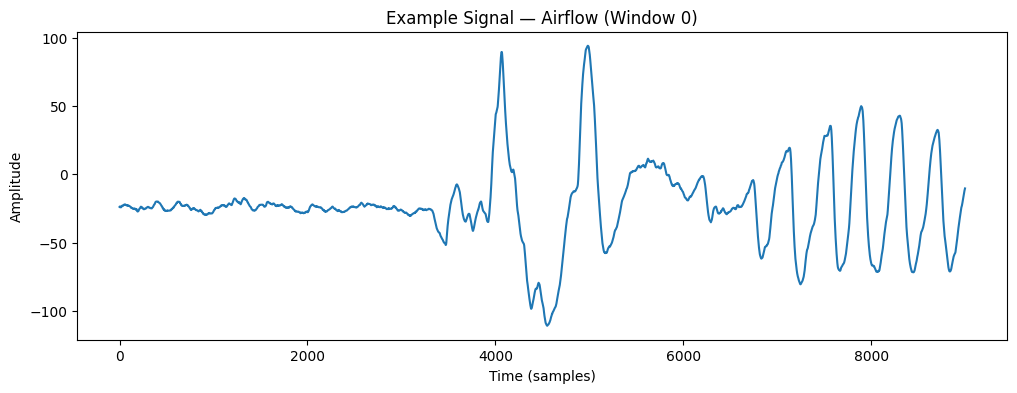

In [9]:
i = 0  # first window
plt.figure(figsize=(12, 4))
plt.plot(signals[i, 1])  # Airflow signal
plt.title("Example Signal — Airflow (Window 0)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


## Possible Biases

Potential dataset biases include:

- **Class imbalance:** Apnea 6.9% (label=1) vs No apnea 93.1%(label=0)
- **Subject imbalance:** Some subjects may contribute more windows than others
- **Night-to-night variability**
- **Different noise levels across sensors**

We first inspect class balance.


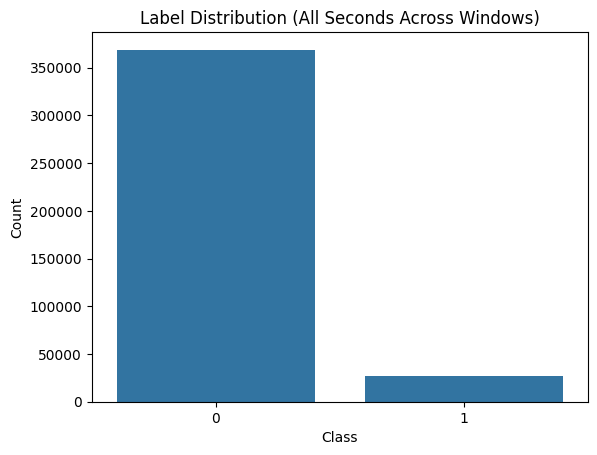

Class proportions: [0.93127778 0.06872222]


In [12]:
label_cols = [c for c in y_df.columns if c.startswith("y_")]

labels_flat = y_df[label_cols].values.ravel()
unique, counts = np.unique(labels_flat, return_counts=True)

sns.barplot(x=unique, y=counts)
plt.title("Label Distribution (All Seconds Across Windows)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Class proportions:", counts / counts.sum())



## Correlations

We explore correlations:

- Between label seconds  
- Between different signals  
- Between subjects and apnea frequency  

Below is an example correlation heatmap of the 90 label values.


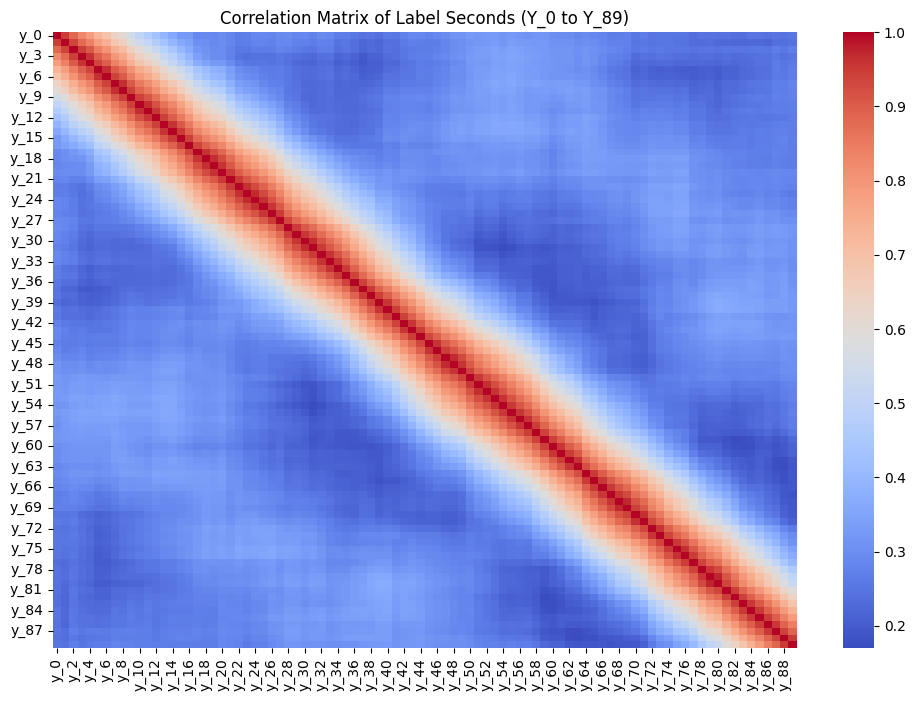

In [ ]:
corr_labels = y_df[label_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_labels, cmap="coolwarm")
plt.title("Correlation Matrix of Label Seconds (Y_0 to Y_89)")
plt.show()


### Interpretation of the Correlation Matrix of Label Seconds (Y_0 to Y_89)

The heatmap above shows the correlation between the 90 binary labels  
(`Y_0` … `Y_89`), representing whether an apnea event is present at each  
second inside a 90-second window.

Several important observations arise:

1. **Strong diagonal structure**  
   The diagonal is bright red, meaning each second is perfectly correlated with itself (correlation = 1).  
   This is expected.

2. **High correlation between neighboring seconds**  
   Seconds close to each other (e.g., Y_23 and Y_24) show strong positive correlation.  
   This creates a red “band” around the diagonal.

   **Reason:** Apnea events are not instantaneous.  
   They typically last **10–30 seconds**, so if one second is labeled 1, the surrounding seconds are also likely to belong to the same episode.

3. **Correlation decreases smoothly as distance increases**  
   As the time difference between labels grows, the correlation gradually decreases.  
   This produces the smooth transition from red → orange → blue.

4. **Low correlation between distant seconds**  
   Seconds far apart within the same window  
   (e.g., Y_0 vs Y_80) are weakly correlated.  
   This is expected because apnea events occupy small portions of the 90-second window.

5. **No obvious irregular patterns or noise artifacts**  
   The matrix exhibits a clean structure, suggesting that:
   - label annotations are consistent,
   - no labeling errors or random patterns are present,
   - apnea events are temporally coherent (clusters of 1s).

### Key Insight
The correlation structure confirms that apnea labels show **temporal continuity**,  
not random spikes.  
This justifies using temporal models such as:
- 1D CNNs,
- dilated convolutions,
- RNNs/GRUs,
- Transformers over the 90-second sequence.

